В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.base import ClassifierMixin
from numpy.random import default_rng



def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

def evaluate_model(model: ClassifierMixin, X_train: pd.DataFrame, y_train: np.ndarray,
                   X_val: pd.DataFrame, y_val: np.ndarray) -> None:
    """
    Обчислює та виводить AUC-ROC для тренувального та валідаційного наборів.

    :param model: Навчена модель (класифікатор).
    :param X_train: pd.DataFrame, тренувальні ознаки.
    :param y_train: np.ndarray, мітки для тренувального набору.
    :param X_val: pd.DataFrame, валідаційні ознаки.
    :param y_val: np.ndarray, мітки для валідаційного набору.
    """
    # Отримання ймовірностей для позитивного класу
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]

    # Обчислення AUC-ROC
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Вивід результатів
    print(f"Train AUC-ROC: {train_auc:.4f}")
    print(f"Validation AUC-ROC: {val_auc:.4f}")

    # Аналіз перенавчання або недонавчання
    if train_auc > val_auc + 0.1:
        print("Є ознаки перенавчання (overfitting).")
    elif val_auc > train_auc + 0.1:
        print("Є ознаки недонавчання (underfitting).")
    else:
        print("Модель збалансована.")

In [69]:
raw_df = pd.read_csv("/content/train.csv")

target_column = "Exited"
# columns_to_keep = ['NumOfProducts', 'Age', 'Geography', 'IsActiveMember', 'Gender', 'Balance']
input_columns = list(raw_df.columns[3:-1])
categorical_columns = list(raw_df.iloc[:, 3:-1].select_dtypes(include=['object']).columns)

train_df, val_df = split_train_val(raw_df, target_column)
train_inputs, train_targets = separate_inputs_targets(train_df, input_columns, target_column)
val_inputs, val_targets = separate_inputs_targets(val_df, input_columns, target_column)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [70]:
train_inputs[categorical_columns] = train_inputs[categorical_columns].astype('category')
val_inputs[categorical_columns] = val_inputs[categorical_columns].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [71]:
xgb_clf = xgb.XGBClassifier(
    max_depth=4,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

# Навчання моделі
xgb_clf.fit(train_inputs, train_targets)
evaluate_model(xgb_clf, train_inputs, train_targets, val_inputs, val_targets)

Train AUC-ROC: 0.9390
Validation AUC-ROC: 0.9346
Модель збалансована.


Модель показала непогані результати, трохи краще ніж у порівнянні з звичайними деревами

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [31]:
!pip install hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [50]:
def objective(params):
    """ Функція для оптимізації гіперпараметрів """
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    model = xgb.XGBClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        objective=params['objective'],
        eval_metric=params['eval_metric'],
        random_state=42,
        enable_categorical=True,
        scale_pos_weight=params['scale_pos_weight'],
    )

    model.fit(train_inputs,
              train_targets,
              verbose=False)
    y_val_pred = model.predict_proba(val_inputs)[:, 1]
    val_auc = roc_auc_score(val_targets, y_val_pred)

    return {'loss': -val_auc, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 5),  # обмежуємо n_estimators
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # зменшуємо верхню межу
    'max_depth': hp.quniform('max_depth', 3, 8, 1),  # обмежуємо глибину дерев
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),  # зменшуємо верхню межу
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),  # зменшуємо верхню межу
    'gamma': hp.uniform('gamma', 0, 0.5),  # зменшуємо верхню межу
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 1),  # додаємо більший мінімум
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 1),  # додаємо більший мінімум
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 10),  # Пошук в межах від 0.5 до 10
}

rng = default_rng(42)

trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=60, trials=trials, rstate=rng)
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
print("Найкращі гіперпараметри:", best_params)


final_clf = xgb.XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    min_child_weight=int(best_params['min_child_weight']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    enable_categorical=True,
    scale_pos_weight=best_params['scale_pos_weight'],

)

final_clf.fit(train_inputs, train_targets)
evaluate_model(final_clf, train_inputs, train_targets, val_inputs, val_targets)

100%|██████████| 60/60 [00:27<00:00,  2.19trial/s, best loss: -0.9370827903148364]
Найкращі гіперпараметри: {'colsample_bytree': 0.6881676159391759, 'gamma': 0.26418365013603673, 'learning_rate': 0.020728588834343496, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 415, 'reg_alpha': 0.6058792480405221, 'reg_lambda': 0.1458331223683984, 'scale_pos_weight': 5.204350950498964, 'subsample': 0.743387475352878}
Train AUC-ROC: 0.9425
Validation AUC-ROC: 0.9371
Модель збалансована.


Модель стала краще, проте спостерігаємо збільшення різниці у показниках на тренувальних та валідаційних даних, хоча загалом відхилення у межах норми.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [9]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [86]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_columns]

lgb_clf = lgb.LGBMClassifier(
    min_data_in_leaf=20,
    max_depth=10,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

evaluate_model(lgb_clf, train_inputs, train_targets, val_inputs, val_targets)

Train AUC-ROC: 0.9592
Validation AUC-ROC: 0.9345
Модель збалансована.


Модель трохи гірша ніж з використанням XGBoostClassifier та і різниця показників між тренувальними та валідаційними даними теж більша.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [110]:
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['min_child_samples'] = int(params['min_child_samples'])
    params['max_bin'] = int(params['max_bin'])
    params['bagging_freq'] = int(params['bagging_freq'])

    model = lgb.LGBMClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        min_child_weight=params['min_child_weight'],
        min_child_samples=params['min_child_samples'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        scale_pos_weight=params['scale_pos_weight'],
        max_bin=params['max_bin'],
        feature_fraction=params['feature_fraction'],
        bagging_fraction=params['bagging_fraction'],
        bagging_freq=params['bagging_freq'],
        objective='binary',
        metric='auc',
        random_state=42,
        verbosity=-1,
        cat_feature=cat_feature_indexes,

    )

    model.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    y_val_pred = model.predict_proba(val_inputs)[:, 1]
    val_auc = roc_auc_score(val_targets, y_val_pred)

    return {'loss': -val_auc, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 1),
    'min_child_weight': hp.quniform('min_child_weight', 3, 10, 1),
    'min_child_samples': hp.quniform('min_child_samples', 20, 50, 5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.05),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 10),
    'max_bin': hp.quniform('max_bin', 32, 256, 32),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'bagging_freq': hp.quniform('bagging_freq', 1, 10, 1),
}

rstate = default_rng(42)
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, rstate=rstate)

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
best_params['max_bin'] = int(best_params['max_bin'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])

print("Найкращі гіперпараметри:", best_params)

final_lgbm_clf = lgb.LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    min_child_weight=best_params['min_child_weight'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    min_split_gain=best_params['min_split_gain'],
    scale_pos_weight=best_params['scale_pos_weight'],
    max_bin=best_params['max_bin'],
    feature_fraction=best_params['feature_fraction'],
    bagging_fraction=best_params['bagging_fraction'],
    bagging_freq=best_params['bagging_freq'],
    objective='binary',
    metric='auc',
    random_state=42,
    verbosity=-1,
    cat_feature=cat_feature_indexes,
)


final_lgbm_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
evaluate_model(final_lgbm_clf, train_inputs, train_targets, val_inputs, val_targets)

100%|██████████| 10/10 [00:09<00:00,  1.01trial/s, best loss: -0.9353501611907539]
Найкращі гіперпараметри: {'bagging_fraction': 0.7292650146614349, 'bagging_freq': 6, 'colsample_bytree': 0.9071555676208776, 'feature_fraction': 0.8180067733076655, 'learning_rate': 0.0246107573547728, 'max_bin': 256, 'max_depth': 5, 'min_child_samples': 30, 'min_child_weight': 7, 'min_split_gain': 0.010297058390819153, 'n_estimators': 275, 'num_leaves': 26, 'reg_alpha': 0.7044600162750467, 'reg_lambda': 0.5924534133258075, 'scale_pos_weight': 2.5160626114366846, 'subsample': 0.7615110681047916}
Train AUC-ROC: 0.9531
Validation AUC-ROC: 0.9354
Модель збалансована.


Модель трохи покращилась, але бачимо різниці між валідаційними та тренувальними даними.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [112]:
test_df = pd.read_csv('/content/test.csv')
test_inputs = test_df[input_columns].copy()
test_inputs[categorical_columns] = test_inputs[categorical_columns].astype('category')
probs = final_clf.predict_proba(test_inputs)[:,1]

submission = pd.read_csv('sample_submission.csv')
submission['Exited'] = probs
submission.to_csv('submission_xgb.csv', index=False)
submission['Exited'].head()

,Exited
0,0.302231
1,0.067161
2,0.275290
3,0.823777
4,0.169351


Обрала бустинг XGBoost, бо він показав кращі результати та різниця метрик на тренувальних та валідаційних даних дуже мала.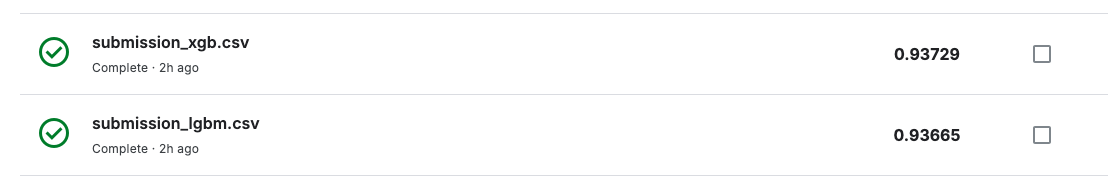